In [73]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [74]:

path=str(pathlib.Path().resolve())+"/"

In [75]:
df=pd.read_csv(path+"Intel_Market.csv")
df

,Fecha,Cerrar/último,Volumen,Abrir,Alto,Bajo
0,03/04/2024,"40,33",83717980,"41,40","41,65","40,22"
1,02/04/2024,"43,94",32748360,"43,925","44,08","43,50"
2,01/04/2024,"44,52",31712590,"44,29","45,41","44,18"
3,28/03/2024,"44,17",54204190,"43,76","44,60","43,71"
4,27/03/2024,"43,77",51017830,"42,54","43,83","42,50"
...,...,...,...,...,...,...
2511,10/04/2014,"26,425",40390460,"27,01","27,09","26,36"
2512,09/04/2014,"26,98",34467000,"26,93","27,02","26,73"
2513,08/04/2014,"26,91",56564370,"26,36","26,98","26,35"
2514,07/04/2014,"26,485",49693490,"26,30","26,74","26,20"


# Tratamiento

Convertimos el campo fecha en fecha y lo seleccionamos como Index para hacerle un rolling, lo cambiamos a formato float el precio de cierre y le hacemos un Rolling de 7 días

In [76]:
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%Y').dt.date
df = df.set_index("Fecha")
df['Cerrar/último'] = df['Cerrar/último'].str.replace(",",".").astype(np.float32)
df = df[['Cerrar/último']].rolling(7).mean().dropna()
df=df[['Cerrar/último']]

Le hacemos un MinMaxScaler de los datos en un rango de 0-1

In [77]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
df_transformed = scaler.fit_transform(df)

Recogemos los datos de Y y de X 
- Y : Valor de mercado
- X : Fecha

In [78]:
X = df_transformed[:-1]
y = df_transformed[1:]

In [79]:
X

array([[0.42192749],
       [0.4296045 ],
       [0.42439509],
       ...,
       [0.03236994],
       [0.03192439],
       [0.03039927]])

In [80]:
#from sklearn.preprocessing import LabelEncoder

#l = LabelEncoder()
#X = l.fit_transform(X)

# División de datos

Dividimos los datos donde:
- Test: Será el 20% del Total del DataSet
- Val: Será el 20% del DataSet restante (16% del Total)
- Train: Será el resto del DataSet un total de 64% del DataSet

In [81]:
from sklearn.model_selection import train_test_split

value = int(len(X)*0.2)
X_train_full, y_train_full, X_test, y_test = X[value:],y[value:],X[:value],y[:value]
X_train, y_train, X_val, y_val = X_train_full[value:],y_train_full[value:],X_train_full[:value],y_train_full[:value]

In [82]:
import numpy as np


#X_train = np.reshape(X_train, (X_train.shape[0], 1))
#X_test = np.reshape(X_test, (X_test.shape[0], 1))

# Red de predicción con 3 Neuronas

Definimos una Red Neuronal con la siguiente arquitectura:
- LSTM (X_neuronas, return_sequences=True, input_shape=[None,1])
- SimpleRNN (X_neuronas, return_sequences=False)
- Dense (1)

In [83]:
"""OJO CON EL RETURN_SEQUENCES"""
import sys


def modelo_red_recurrente_3(x_train, y_train,n_neuronas,x_val,y_val):
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
    # return_sequences significa que solo de salida por Vector no por secuencia, lo que hará que vayan todas de vez
    model = keras.models.Sequential([
        keras.layers.LSTM(n_neuronas, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(n_neuronas, return_sequences=False),
        keras.layers.Dense(1)
    ])
    model.compile(loss="mse", optimizer="adam")
    model.fit(x_train, y_train, epochs=sys.maxsize,validation_data=[x_val,y_val],callbacks=[early_stopping_cb])
    return model

Le decimos que use 40 neuronas y compruebe el Mean_squared_error para ver el resultado que ronda sobre 0.00X

In [84]:
from sklearn.metrics import mean_squared_error


modelo = modelo_red_recurrente_3(X_train, y_train,40,X_val,y_val)
y_pred = modelo.predict(X_test)

rms = mean_squared_error(y_test, y_pred, squared=False)
print(f"rms modelo_red_recurrente_1 = {rms}")

Epoch 1/9223372036854775807
48/48 [==============================] - 3s 14ms/step - loss: 0.0626 - val_loss: 0.0309
Epoch 2/9223372036854775807
48/48 [==============================] - 0s 3ms/step - loss: 0.0141 - val_loss: 0.0120
Epoch 3/9223372036854775807
48/48 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 1.6963e-04
Epoch 4/9223372036854775807
48/48 [==============================] - 0s 3ms/step - loss: 6.3165e-05 - val_loss: 1.3471e-04
Epoch 5/9223372036854775807
48/48 [==============================] - 0s 3ms/step - loss: 5.6222e-05 - val_loss: 1.2270e-04
Epoch 6/9223372036854775807
48/48 [==============================] - 0s 3ms/step - loss: 5.6248e-05 - val_loss: 1.2790e-04
Epoch 7/9223372036854775807
48/48 [==============================] - 0s 3ms/step - loss: 5.5314e-05 - val_loss: 1.2055e-04
Epoch 8/9223372036854775807
48/48 [==============================] - 0s 3ms/step - loss: 5.5234e-05 - val_loss: 1.2184e-04
Epoch 9/9223372036854775807
48/48 [

Mostramos un gráfico de barras que va de X-train a (X_test | X_pred), para comparar la predicción con los datos reales

- Creación de una constante ALL para ver la comparativa 50 datos - 50 datos de prediccion | 50 datos de test

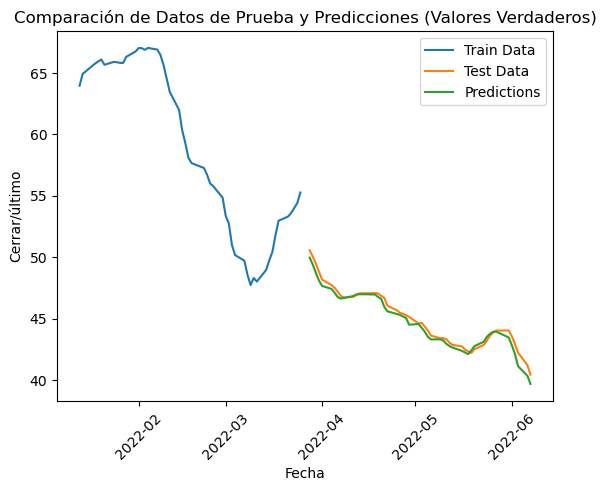

In [85]:
import matplotlib.pyplot as plt

ALL = False

V_Test = len(X_test) if ALL else 50
V_Train = len(X_train) if ALL else 50
# Concatenar los índices de train y test para plotear
index_train = df.index[len(X_test):][:V_Train]
index_test = df.index[:len(X_test)][-V_Test:]

# Invertir la transformación de MinMaxScaler para obtener los valores verdaderos
y_train_inverse = scaler.inverse_transform(y_train)
y_test_inverse = scaler.inverse_transform(y_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

# Plot de datos de entrenamiento
plt.plot(index_train, y_train_inverse[:V_Train], label='Train Data')

# Plot de datos de prueba
plt.plot(index_test, y_test_inverse[-V_Test:], label='Test Data')

# Plot de predicciones
plt.plot(index_test, y_pred_inverse[-V_Test:], label='Predictions')

plt.title('Comparación de Datos de Prueba y Predicciones (Valores Verdaderos)')
plt.xlabel('Fecha')
plt.ylabel('Cerrar/último')
plt.legend()
plt.xticks(rotation=45)
plt.show()



In [86]:
def genera_train(serie,lg_secuencia,lg_y):
    """Genera el set de entrenamiento

    Args:
        serie (pd.Serie): Serie de datos
        lg_secuencia (int): Longitud de la secuencia
        lg_y (int): Longitud de los datos recogidos
    """
    # Imaginemos que es de 20 entonces será 1000 - 20 - los valores que vamos recoger
    x=[]
    y=[]
    ultimo = len(serie)-lg_secuencia-lg_y
    for ix in range(ultimo):
      x.append(serie[ix:ix+lg_secuencia])
      y.append(serie[ix+lg_secuencia:ix+lg_secuencia+lg_y])
    return np.array(x), np.array(y)

X,y=genera_train(df_transformed,50,10)
value = int(len(X)*0.2)
X_train_full, y_train_full, X_test, y_test = X[value:],y[value:],X[:value],y[:value]
X_train, y_train, X_val, y_val = X_train_full[value:],y_train_full[value:],X_train_full[:value],y_train_full[:value]

In [87]:
y_test = y_test.reshape((y_test.shape[0],y_test.shape[1]))
y_train = y_train.reshape((y_train.shape[0],y_train.shape[1]))
y_val = y_val.reshape((y_val.shape[0],y_val.shape[1]))

In [88]:
lg_y = 10
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
rnn_predice_10 = keras.models.Sequential([
    keras.layers.SimpleRNN(40, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(40),
    keras.layers.Dense(lg_y)
    ])
rnn_predice_10.compile(loss="mse", optimizer="adam")

In [89]:
rnn_predice_10.fit(X_train, y_train,epochs=sys.maxsize,validation_data=[X_val,y_val],callbacks=[early_stopping_cb])

Epoch 1/9223372036854775807
46/46 [==============================] - 2s 18ms/step - loss: 0.0542 - val_loss: 0.0281
Epoch 2/9223372036854775807
46/46 [==============================] - 1s 11ms/step - loss: 0.0046 - val_loss: 0.0099
Epoch 3/9223372036854775807
46/46 [==============================] - 1s 11ms/step - loss: 0.0028 - val_loss: 0.0079
Epoch 4/9223372036854775807
46/46 [==============================] - 1s 11ms/step - loss: 0.0022 - val_loss: 0.0062
Epoch 5/9223372036854775807
46/46 [==============================] - 1s 12ms/step - loss: 0.0019 - val_loss: 0.0054
Epoch 6/9223372036854775807
46/46 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.0048
Epoch 7/9223372036854775807
46/46 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.0050
Epoch 8/9223372036854775807
46/46 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 0.0051
Epoch 9/9223372036854775807
46/46 [==============================] - 1s 

In [90]:
y_pred = rnn_predice_10.predict(X_test)
#nsamples, nx, ny = y_pred.shape
#y_pred = X_test.reshape((nsamples,nx*ny))
y_test = y_test.reshape((y_test.shape[0],y_test.shape[1]))
rms = mean_squared_error(y_test, y_pred, squared=False)
print(f"rms rnn_predice_10 = {rms}")

16/16 [==============================] - 0s 5ms/step
rms rnn_predice_10 = 0.033843967576864156
